# Travel Destination Analysis & Recommendation System

# Import all libraries

In [42]:
import pandas as pd
import matplotlib.pyplot as plt 
import csv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import numpy as np
import re
from sentence_transformers import SentenceTransformer
import faiss

# Load and clean data

In [43]:
csv_path = "../data/destinations_cleaned.csv"
df = pd.read_csv(csv_path, encoding='utf-8')


# Replace missing or empty descriptions

In [44]:
df["Description"] = df["Description"].fillna("").replace(r"^\s*$", "Description not found.", regex=True)
df["Description"] = df["Description"].apply(lambda x: x if isinstance(x, str) else "Description not found.")

# Clean approximate annual tourists column

In [45]:
def parse_tourist_count(value):
    if isinstance(value, (int, float)):
        return value
    if pd.isna(value):
        return None
    s = str(value).lower().strip().replace(',', '')
    if "million" in s:
        s = s.replace("million", "").strip()
        if '-' in s:
            parts = s.split('-')
            try:
                nums = [float(part.strip()) for part in parts if part.strip()]
                return sum(nums) / len(nums)
            except ValueError:
                return None
        else:
            try:
                return float(s)
            except ValueError:
                return None
    else:
        if '-' in s:
            parts = s.split('-')
            try:
                nums = [float(part.strip()) for part in parts if part.strip()]
                raw = sum(nums) / len(nums)
            except ValueError:
                return None
        else:
            try:
                raw = float(s)
            except ValueError:
                return None
        return raw / 1e6

if "Approximate Annual Tourists" in df.columns:
    df["Approximate Annual Tourists(million)"] = df["Approximate Annual Tourists"].apply(parse_tourist_count)

# EDA: Tourist Distribution by Country

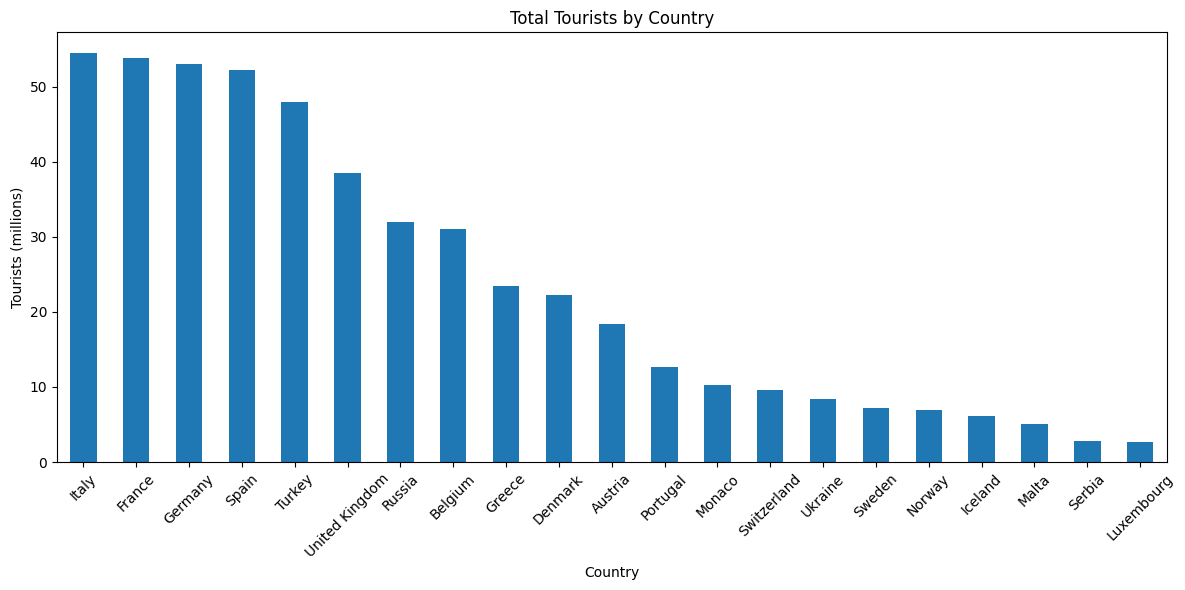

In [46]:
plt.figure(figsize=(12, 6))
country_counts = df.groupby("Country")["Approximate Annual Tourists(million)"].sum().sort_values(ascending=False)
country_counts.plot(kind='bar')
plt.title("Total Tourists by Country")
plt.ylabel("Tourists (millions)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# EDA: Count of Destinations per Category

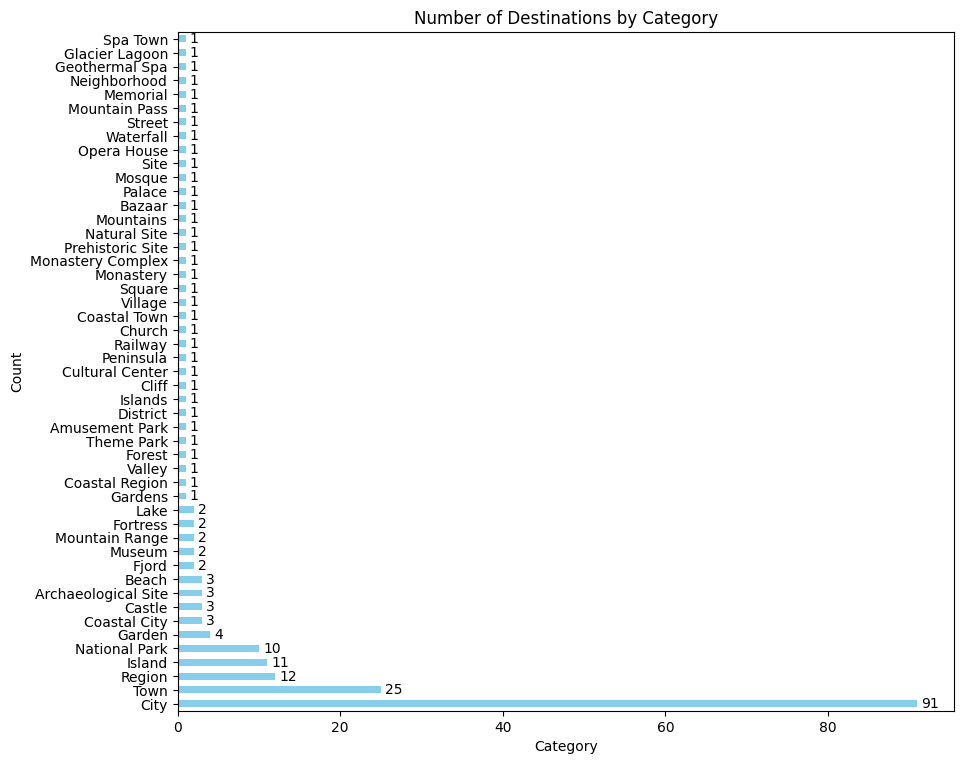

In [47]:
category_counts = df["Category"].value_counts().sort_values(ascending = False)

plt.figure(figsize=(10, 8))
category_counts.plot(kind="barh", color="skyblue")
plt.title("Number of Destinations by Category")
plt.xlabel("Category")
plt.ylabel("Count")
for index, value in enumerate(category_counts):
    plt.text(value + .5, index, str(int(value)), va = 'center')
plt.yticks(ticks=range(len(category_counts)), labels=category_counts.index, fontsize=10)
plt.tight_layout(pad = 2.0)
plt.show()

# Broad Category Mapping </br>
From the graph above, there are too many different categories than I previously anticipated, I am grouping them into broader categories.

In [48]:
category_map = {
    # Wellness & Relaxation
    "Spa Town": "Wellness",
    "Geothermal Spa": "Wellness",

    # Nature
    "Glacier Lagoon": "Nature",
    "Natural Site": "Nature",
    "Waterfall": "Nature",
    "Mountain Pass": "Nature",
    "Cliff": "Nature",
    "Valley": "Nature",
    "Lake": "Nature",
    "Fjord": "Nature",
    "Forest": "Nature",
    "Mountain Range": "Nature",
    "Mountains": "Nature",
    "Island": "Nature",
    "Islands": "Nature",
    "Peninsula": "Nature",
    "National Park": "Nature",
    "Gardens": "Nature",
    "Garden": "Nature",

    # Urban / Human Settlements
    "City": "Urban",
    "Town": "Urban",
    "Village": "Urban",
    "Region": "Urban",
    "District": "Urban",
    "Neighborhood": "Urban",
    "Coastal Town": "Urban",
    "Coastal Region": "Urban",
    "Coastal City": "Urban",
    "Square": "Urban",
    "Street": "Urban",

    # History & Culture
    "Prehistoric Site": "History & Culture",
    "Memorial": "History & Culture",
    "Monastery": "History & Culture",
    "Monastery Complex": "History & Culture",
    "Mosque": "History & Culture",
    "Church": "History & Culture",
    "Cultural Center": "History & Culture",
    "Palace": "History & Culture",
    "Bazaar": "History & Culture",
    "Opera House": "History & Culture",
    "Fortress": "History & Culture",
    "Castle": "History & Culture",
    "Archaeological Site": "History & Culture",
    "UNESCO Site": "History & Culture",
    "Site": "History & Culture",  # Only 1 entry: Chernobyl Exclusion Zone

    # Museums & Arts
    "Museum": "Museum & Arts",

    # Beaches
    "Beach": "Beach",

    # Entertainment
    "Theme Park": "Entertainment",
    "Amusement Park": "Entertainment",

    # Transportation
    "Railway": "Transportation"

    
}
df["Broad Category"] = df["Category"].map(category_map)
df.head()

,Destination,Region,Country,Category,Latitude,Longitude,Approximate Annual Tourists(million),Currency,Majority Religion,Famous Foods,Language,Best Time to Visit,Cost of Living,Safety,Cultural Significance,Description,Broad Category
0,Rome,Lazio,Italy,City,41.902782,12.496366,14.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",Italian,Spring (April-May) or Fall (Sept-Oct),Medium-high,"Generally safe, but watch out for pickpockets","The capital city, known for its historical lan...","A hub of ancient history and modern culture, w...",Urban
1,Florence,Tuscany,Italy,City,43.769581,11.255772,10.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",Italian,Spring (April-May) or Fall (Sept-Oct),Medium-high,"Generally safe, but watch out for pickpockets","A Renaissance city famous for its art, archite...","Home to world-class museums, including the Uff...",Urban
2,Venice,Veneto,Italy,City,45.435559,12.336196,10.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",Italian,Spring (April-May) or Fall (Sept-Oct),Medium-high,"Generally safe, but watch out for pickpockets","A unique city built on canals, known for its g...","An iconic city of water, renowned for romantic...",Urban
3,Milan,Lombardy,Italy,City,45.464643,9.188540,7.0,Euro,Roman Catholic,"Risotto, Ossobuco, Panettone",Italian,Spring (April-May) or Fall (Sept-Oct),High,"Generally safe, but watch out for pickpockets","A fashion capital known for its shopping, muse...","A modern city with an ancient soul, featuring ...",Urban
4,Naples,Campania,Italy,City,40.851330,14.254720,5.0,Euro,Roman Catholic,"Pizza, Pasta, Cannoli",Italian,Spring (April-May) or Fall (Sept-Oct),Medium,"Generally safe, but be aware of pickpockets","A vibrant city known for its delicious food, h...","Famous for pizza, Pompeii, and proximity to th...",Urban


# Extracting best time to visit

In [49]:
import re

def extract_seasons(text):
    if pd.isna(text):
        return "Unknown"
    text = text.lower()
    seasons = []
    if "spring" in text:
        seasons.append("Spring")
    if "summer" in text:
        seasons.append("Summer")
    if "fall" in text:
        seasons.append("Fall")
    if "winter" in text:
        seasons.append("Winter")
    if "year-round" in text:
        seasons.append("Year-round")
    return ", ".join(seasons) if seasons else "Unknown"

# Apply to column
df["Season"] = df["Best Time to Visit"].apply(extract_seasons)
print(df['Season'].unique())

['Spring, Fall' 'Summer' 'Summer, Winter' 'Year-round']


# One-hot encoding

Machine‑learning models (especially linear models, tree ensembles, neural nets, SVMs, etc.) can only work with numbers. Encoding turns your human‑readable categories into numeric vectors so that:

    - Algorithms can compute distances or weights (e.g. coefficient * feature).

    - You don’t accidentally impose an ordering (one‑hot means “red,” “green,” and “blue” are equidistant).

    - Ordinal info is preserved (a label encoder on “low/med/high” respects that order).

In [50]:
#multi label one-hot encoding for seasons
from sklearn.preprocessing import MultiLabelBinarizer


df["Season List"] = df["Season"].str.split(", ")
mlb = MultiLabelBinarizer()
season_dummies = pd.DataFrame(
    mlb.fit_transform(df["Season List"]),
    columns=mlb.classes_,
    index=df.index
)
df = pd.concat([df, season_dummies], axis=1)

print(df['Majority Religion'].unique())
religion_dummies = df['Majority Religion'].str.get_dummies(sep=', ')
df = df.join(religion_dummies)

print(df['Cost of Living'].unique()) #cost is ordinal, 
cost_map = {
    "Free":            0,
    "Medium":          1,
    "Medium-high":     2,
    "High":            3,
    "Extremely high":  4,
    "Varies":          5,
}
df['cost_enc'] = df['Cost of Living'].map(cost_map)

print(df['Language'].unique())
clean = (
    df['Language']
      # 1a. drop parentheses
      .str.replace(r'[()]', '', regex=True)

      # 1b. turn “and” (any case, any surrounding spaces) into a comma
      .str.replace(r'(?i)\s*\band\b\s*', ', ', regex=True)

      # 1c. turn any other delimiters you use into commas
      .str.replace(r'[;/]', ',', regex=True)

      # 1d. collapse multiple commas / spaces, strip ends
      .str.replace(r'\s*,\s*', ', ', regex=True)   # tidy commas
      .str.replace(r'\s+', ' ', regex=True)        # collapse whitespace
      .str.strip(' ,')                             # trim leftover ,/space
)
lan_dummies = clean.str.get_dummies(sep=', ')
df = df.join(lan_dummies)
print(clean.unique())

df.head()


['Roman Catholic' 'Protestant' 'Russian Orthodox'
 'Muslim, Russian Orthodox' 'Greek Orthodox' 'Muslim' 'Ukrainian Orthodox'
 'Christian (Anglican)' 'Christian (Presbyterian)' 'Serbian Orthodox']
['Medium-high' 'High' 'Medium' 'Free' 'Extremely high' 'Varies']
['Italian' 'Spanish' 'Spanish (and Basque)' 'French' 'French (and German)'
 'German' 'Dutch, French' 'Danish' 'French, Monegasque' 'Russian'
 'Russian, Tatar' 'Greek' 'Portuguese' 'Norwegian' 'Swedish'
 'German, French, Italian' 'French, German' 'German, French' 'Turkish'
 'Ukrainian' 'English' 'English, Scottish Gaelic'
 'Luxembourgish, French, German' 'Maltese, English' 'Icelandic' 'Serbian'
 'Serbian, Hungarian']
['Italian' 'Spanish' 'Spanish, Basque' 'French' 'French, German' 'German'
 'Dutch, French' 'Danish' 'French, Monegasque' 'Russian' 'Russian, Tatar'
 'Greek' 'Portuguese' 'Norwegian' 'Swedish' 'German, French, Italian'
 'German, French' 'Turkish' 'Ukrainian' 'English'
 'English, Scottish Gaelic' 'Luxembourgish, French,

,Destination,Region,Country,Category,Latitude,Longitude,Approximate Annual Tourists(million),Currency,Majority Religion,Famous Foods,...,Norwegian,Portuguese,Russian,Scottish Gaelic,Serbian,Spanish,Swedish,Tatar,Turkish,Ukrainian
0,Rome,Lazio,Italy,City,41.902782,12.496366,14.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",...,0,0,0,0,0,0,0,0,0,0
1,Florence,Tuscany,Italy,City,43.769581,11.255772,10.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",...,0,0,0,0,0,0,0,0,0,0
2,Venice,Veneto,Italy,City,45.435559,12.336196,10.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",...,0,0,0,0,0,0,0,0,0,0
3,Milan,Lombardy,Italy,City,45.464643,9.188540,7.0,Euro,Roman Catholic,"Risotto, Ossobuco, Panettone",...,0,0,0,0,0,0,0,0,0,0
4,Naples,Campania,Italy,City,40.851330,14.254720,5.0,Euro,Roman Catholic,"Pizza, Pasta, Cannoli",...,0,0,0,0,0,0,0,0,0,0


In [51]:
print(df['Safety'].unique())
risk_patterns = {
    'pickpockets': r'pickpocket',
    'crowds':      r'crowd',
    'wildlife':    r'bear',
    'conflict':    r'ongoing conflict',
    'generic_risk':r'potential risks?',
    'restricted':  r'restricted access'
}
def parse_risks(text):
    return {k: bool(re.search(pat, text, re.I)) for k, pat in risk_patterns.items()}

def severity(row):
    if row['restricted']:           return 3
    if row[['conflict']].any():     return 3
    if row[['pickpockets','crowds','wildlife','generic_risk']].any(): return 2
    return 1                        # plain “Generally safe”

parsed = df['Safety'].apply(parse_risks).apply(pd.Series)
df = pd.concat([df, parsed], axis=1)
df['safety_severity'] = df.apply(severity, axis=1)
df.head()

['Generally safe, but watch out for pickpockets'
 'Generally safe, but be aware of pickpockets'
 'Generally safe, but be aware of crowds' 'Generally safe'
 'Generally safe, but watch for pickpockets'
 'Generally safe, but be aware of bears'
 'Generally safe, but be aware of ongoing conflict'
 'Generally safe, but be aware of potential risks' 'Restricted access']


,Destination,Region,Country,Category,Latitude,Longitude,Approximate Annual Tourists(million),Currency,Majority Religion,Famous Foods,...,Tatar,Turkish,Ukrainian,pickpockets,crowds,wildlife,conflict,generic_risk,restricted,safety_severity
0,Rome,Lazio,Italy,City,41.902782,12.496366,14.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",...,0,0,0,True,False,False,False,False,False,2
1,Florence,Tuscany,Italy,City,43.769581,11.255772,10.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",...,0,0,0,True,False,False,False,False,False,2
2,Venice,Veneto,Italy,City,45.435559,12.336196,10.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",...,0,0,0,True,False,False,False,False,False,2
3,Milan,Lombardy,Italy,City,45.464643,9.188540,7.0,Euro,Roman Catholic,"Risotto, Ossobuco, Panettone",...,0,0,0,True,False,False,False,False,False,2
4,Naples,Campania,Italy,City,40.851330,14.254720,5.0,Euro,Roman Catholic,"Pizza, Pasta, Cannoli",...,0,0,0,True,False,False,False,False,False,2


# Building SBERT (Sentence Embedding)
I am combining the destination name and cultural significance columns

In [52]:
# Choose / load an SBERT model
model_name = 'paraphrase-MiniLM-L6-v2'            # 384‑d, small & quick
model = SentenceTransformer(model_name)

#  Compose the text you’ll embed
text_col = (
    df['Destination'] + '. ' +                   # title helps queries like “Paris”
    df['Cultural Significance'].fillna('')
).tolist()

# Encode (batch‑encoded, GPU‑friendly, 1000 rows ≈ 2 s on CPU)
emb = model.encode(
    text_col,
    batch_size=64,
    show_progress_bar=True,
    normalize_embeddings=True     # makes cosine == dot‑product
).astype('float32')               # faiss wants float32

# Build the ANN index.  For < 50 k rows a flat index is fine.
dim = emb.shape[1]                # 384
index = faiss.IndexFlatIP(dim)    # inner product ≈ cosine when vectors are unit‑norm
index.add(emb)                    # (N, dim)

# Persist to disk so you don’t re‑encode every run
faiss.write_index(index, "destinations.ip") # using the facebook AI similarity search to speed up the look-up
np.save("embeddings.npy", emb)

Batches: 100%|██████████| 4/4 [00:00<00:00, 25.85it/s]


# Testing the SBERT

In [ ]:
index = faiss.read_index("destinations.ip")
def search_destinations(query:str, k:int=10, safety_filter:bool=True, columns: list = None):
    qvec = model.encode(query, normalize_embeddings=True)
    D, I = index.search(qvec[None, :].astype('float32'), k= k*3)  # over‑fetch
    hits = df.iloc[I[0]].copy()
    # qvec: embeds query into the same vector space as destinations data
    # D: similiarity score 
    # I: indices of top matches in the data
    
    # Optional: apply rule‑based filters AFTER scoring
    if safety_filter:
        hits = hits[~hits['Safety'].str.contains('ongoing conflict|Restricted', case=False)]
        
    if columns:
        hits = hits[columns]

    return hits.head(k)           # final top‑K

# 🔍 Example
print(search_destinations("snowy wildlife photography spots", k=5, columns = ["Destination", "Cultural Significance"]))

           Destination                              Cultural Significance
141            Antalya  Popular coastal city with beaches and ancient ...
98             Nafplio  Historic city known for Venetian fortress, cha...
70        Monaco-Ville  Historic old town known for its Prince's Palac...
205  Novi Sad Fortress  A historic fortress overlooking the Danube Riv...
175    Beaufort Castle  A medieval castle perched on a hilltop, offeri...
